In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Binarizer, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_feather('final.feather')
df.head()

,Hydro,Solar,Wind,eia_region,demand_mwh,tavg,wspd,prcp,poa,month_year,label
0,2766.0,1859.0,3334.0,California,2042244.347,11.777419,2.519355,0.338710,887638,2022-01-01,Medium High
1,2322.0,31.0,0.0,Carolinas,2075169.565,4.939785,9.820430,11.667742,776742,2022-01-01,High
2,1304.0,0.0,17695.0,Central,4539319.095,-1.819355,16.219355,1.480645,713940,2022-01-01,High
3,33.0,8.0,0.0,Florida,1813852.253,16.555914,12.197849,6.345161,618925,2022-01-01,Low
4,3044.0,17.0,3494.0,Mid-Atlantic,4413106.059,-1.503226,9.227957,9.493548,637646,2022-01-01,High


# Multinomial NB

In [3]:
df.columns

Index(['Hydro', 'Solar', 'Wind', 'eia_region', 'demand_mwh', 'tavg', 'wspd',
       'prcp', 'poa', 'month_year', 'label'],
      dtype='object')

In [4]:
mnb_df = df.copy()
## Prep data by one-hot encoding `eia_region` and `month_year`, and binning continuous variables into counts as well
### Strip `month_year` to just `month` for one-hot encoding
mnb_df['month'] = mnb_df['month_year'].dt.month
mnb_df.drop(columns=['month_year', 'demand_mwh'], inplace=True)
### Discretize continuous variables
cols = ['Hydro', 'Solar', 'Wind','tavg', 'wspd', 'prcp', 'poa',]
for col in cols:
    mnb_df[col] = pd.cut(mnb_df[col], bins=5, labels=False)
### One-hot encode `eia_region` and `month`
ohe = OneHotEncoder(sparse_output=False)
encoded = ohe.fit_transform(mnb_df[['eia_region', 'month']])
### Concatentate one-hot encoded columns to dataframe
mnb_df = pd.concat([mnb_df, pd.DataFrame(encoded, columns=ohe.get_feature_names_out(['eia_region', 'month']))], axis=1)
### Drop original columns
mnb_df.drop(columns=['eia_region', 'month'], inplace=True)
mnb_df.head().to_feather('mnb_df_head.feather')


Accuracy: 0.625933230032399
Classification Report:
              precision    recall  f1-score   support

        High       0.75      0.71      0.73      7421
         Low       0.68      0.74      0.71      6678
 Medium High       0.56      0.54      0.55      7400
  Medium Low       0.51      0.52      0.52      6897

    accuracy                           0.63     28396
   macro avg       0.63      0.63      0.63     28396
weighted avg       0.63      0.63      0.63     28396



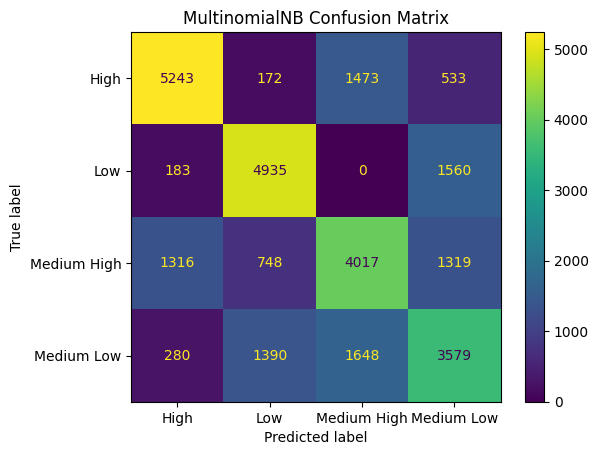

In [23]:
### Split data into training and testing sets
mnb_train_df, mnb_test_df = train_test_split(mnb_df, test_size=0.25, random_state=42)
mnb_train_df.head().to_feather('mnb_train_df.feather')
mnb_test_df.head().to_feather('mnb_test_df.feather')

mnb_x_train = mnb_train_df.drop(columns='label')
mnb_y_train = mnb_train_df['label']

mnb_x_test = mnb_test_df.drop(columns='label')
mnb_y_test = mnb_test_df['label']

mnb = MultinomialNB().fit(mnb_x_train, mnb_y_train)

mnb_y_pred = mnb.predict(mnb_x_test)

accuracy = accuracy_score(mnb_y_test, mnb_y_pred)
report = classification_report(mnb_y_test, mnb_y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm = confusion_matrix(mnb_y_test, mnb_y_pred, labels=mnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mnb.classes_)
disp.plot()
plt.title('MultinomialNB Confusion Matrix')
plt.savefig('../images/mnb_confusion_matrix.png')
plt.show()

# Guassian NB

Accuracy: 0.48401183265248626
Classification Report:
              precision    recall  f1-score   support

        High       0.51      0.98      0.67      7421
         Low       0.47      0.97      0.63      6678
 Medium High       0.00      0.00      0.00      7400
  Medium Low       0.00      0.00      0.00      6897

    accuracy                           0.48     28396
   macro avg       0.24      0.49      0.32     28396
weighted avg       0.24      0.48      0.32     28396



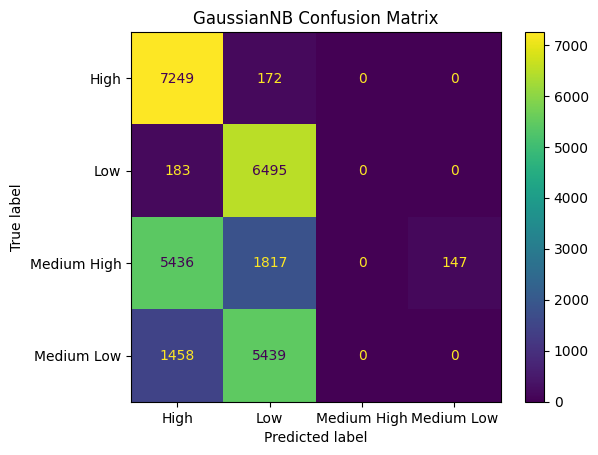

In [24]:
gnb_df = df.copy()
## Prep data by one-hot encoding `eia_region` and `month_year`, and normalizing continuous variables
### Strip `month_year` to just `month` for one-hot encoding
gnb_df['month'] = gnb_df['month_year'].dt.month
gnb_df.drop(columns=['month_year', 'demand_mwh'], inplace=True)
### Normalize continuous variables


X = gnb_df.drop(columns='label')
y = gnb_df['label']

numeric_features = ['Hydro', 'Solar', 'Wind', 'tavg', 'wspd', 'prcp', 'poa']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['eia_region', 'month']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_preprocessed = preprocessor.fit_transform(X)

gnb_x_train, gnb_x_test, gnb_y_train, gnb_y_test = train_test_split(X_preprocessed, y, test_size=0.25, random_state=42)
pd.DataFrame(gnb_x_train).head().to_feather('gnb_x_train.feather')
pd.DataFrame(gnb_x_test).head().to_feather('gnb_x_test.feather')
gnb_model = GaussianNB().fit(gnb_x_train, gnb_y_train)
gnb_y_pred = gnb_model.predict(gnb_x_test)
accuracy = accuracy_score(gnb_y_test, gnb_y_pred)
report = classification_report(gnb_y_test, gnb_y_pred, zero_division=0)
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm = confusion_matrix(gnb_y_test, gnb_y_pred, labels=gnb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb_model.classes_)
disp.plot()
plt.title('GaussianNB Confusion Matrix')
plt.savefig('../images/gnb_confusion_matrix.png')
plt.show()

# Bernoulli NB

Accuracy: 0.698901253697704
Classification Report:
              precision    recall  f1-score   support

        High       0.79      0.78      0.79      7421
         Low       0.76      0.76      0.76      6678
 Medium High       0.65      0.63      0.64      7400
  Medium Low       0.60      0.63      0.61      6897

    accuracy                           0.70     28396
   macro avg       0.70      0.70      0.70     28396
weighted avg       0.70      0.70      0.70     28396



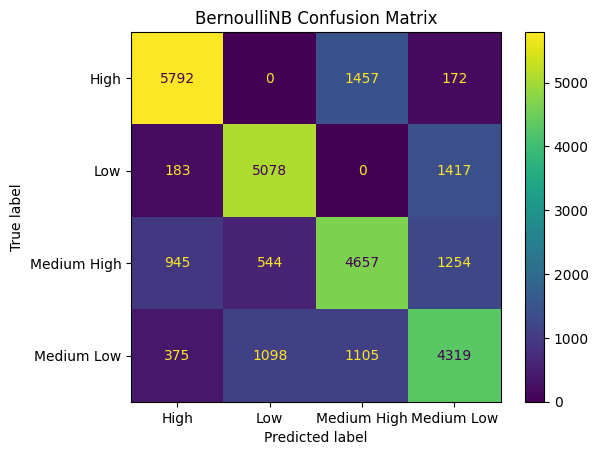

In [7]:
X = gnb_df.drop(columns='label')
y = gnb_df['label']

numeric_features = ['Hydro', 'Solar', 'Wind', 'tavg', 'wspd', 'prcp', 'poa']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', Binarizer())])

categorical_features = ['eia_region', 'month']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_preprocessed = preprocessor.fit_transform(X)

bnb_x_train, bnb_x_test, bnb_y_train, bnb_y_test = train_test_split(X_preprocessed, y, test_size=0.25, random_state=42)
pd.DataFrame(bnb_x_train).to_feather('bnb_x_train.feather')
pd.DataFrame(bnb_x_test).to_feather('bnb_x_test.feather')

bnb_model = BernoulliNB().fit(bnb_x_train, bnb_y_train)
bnb_y_pred = bnb_model.predict(bnb_x_test)

accuracy = accuracy_score(bnb_y_test, bnb_y_pred)
report = classification_report(bnb_y_test, bnb_y_pred,)
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm = confusion_matrix(bnb_y_test, bnb_y_pred, labels=bnb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bnb_model.classes_)
disp.plot()
plt.title('BernoulliNB Confusion Matrix')
plt.savefig('../images/bnb_confusion_matrix.png')
plt.show()


# Decision Tree

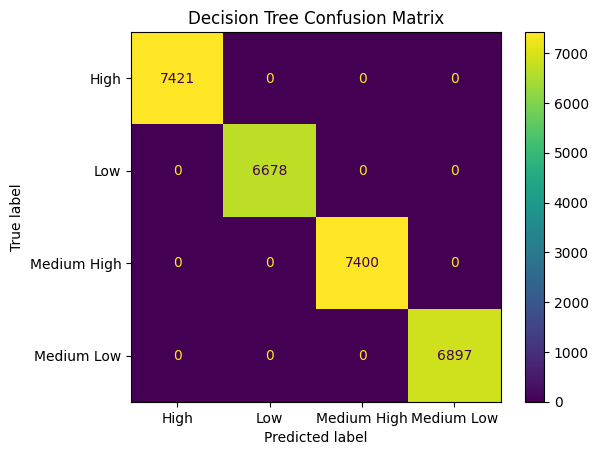

In [36]:
dt_df = df.copy()
dt_df['month'] = dt_df['month_year'].dt.month
dt_x_df = dt_df.drop(columns='label')
dt_y_df = dt_df['label']

# Define preprocessing for numeric columns (impute missing values)
numeric_features = ['Hydro', 'Solar', 'Wind', 'tavg', 'wspd', 'prcp', 'poa']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Define preprocessing for categorical columns (one-hot encode)
categorical_features = ['eia_region', 'month']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
dt_X_preprocessed = preprocessor.fit_transform(dt_x_df)


dt_x_train, dt_x_test, dt_y_train, dt_y_test = train_test_split(dt_X_preprocessed, dt_y_df, test_size=0.25, random_state=42)
pd.DataFrame(dt_x_train).head().to_feather('dt_x_train.feather')
pd.DataFrame(dt_x_test).head().to_feather('dt_x_test.feather')



dt_model = DecisionTreeClassifier().fit(dt_x_train, dt_y_train)
dt_y_pred = dt_model.predict(dt_x_test)

from sklearn.tree import export_graphviz
import graphviz

categorical_feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features).tolist()
feature_names = numeric_features + categorical_feature_names

dot_data = export_graphviz(dt_model, out_file=None, feature_names=feature_names, class_names=dt_model.classes_, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('../images/dt_graph', format='png')

cm = confusion_matrix(dt_y_test, dt_y_pred, labels=dt_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot()
plt.title('Decision Tree Confusion Matrix')
plt.savefig('../images/dt_confusion_matrix.png')
plt.show()

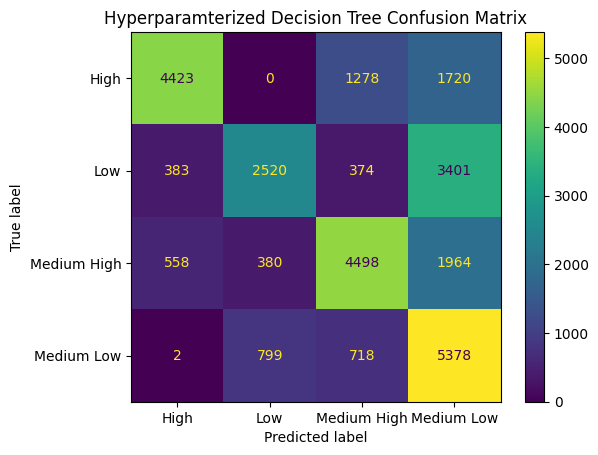

Accuracy: 0.5923017326383998
Classification Report:
              precision    recall  f1-score   support

        High       0.82      0.60      0.69      7421
         Low       0.68      0.38      0.49      6678
 Medium High       0.65      0.61      0.63      7400
  Medium Low       0.43      0.78      0.56      6897

    accuracy                           0.59     28396
   macro avg       0.65      0.59      0.59     28396
weighted avg       0.65      0.59      0.59     28396



In [45]:
dt_no_tavg = dt_df.copy()
dt_x_no_tavg = dt_no_tavg.drop(columns=['label', 'tavg',])
dt_y_no_tavg = dt_no_tavg['label']

# Define preprocessing for numeric columns (impute missing values)
numeric_features = ['Hydro', 'Solar', 'Wind', 'wspd', 'prcp', 'poa']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Define preprocessing for categorical columns (one-hot encode)
categorical_features = ['eia_region','month']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
dt_X_preprocessed = preprocessor.fit_transform(dt_x_no_tavg)


dt_x_train, dt_x_test, dt_y_train, dt_y_test = train_test_split(dt_X_preprocessed, dt_y_no_tavg, test_size=0.25, random_state=42)
# pd.DataFrame(dt_x_train).to_feather('dt_x_train.feather')
# pd.DataFrame(dt_x_test).to_feather('dt_x_test.feather')



dt_model = DecisionTreeClassifier(max_depth=6, max_features='sqrt', random_state=42).fit(dt_x_train, dt_y_train)
dt_y_pred = dt_model.predict(dt_x_test)

from sklearn.tree import export_graphviz
import graphviz

categorical_feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features).tolist()
feature_names = numeric_features + categorical_feature_names

dot_data = export_graphviz(dt_model, out_file=None, feature_names=feature_names, class_names=dt_model.classes_, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('../images/dt_graph_no_tavg', format='png')

cm = confusion_matrix(dt_y_test, dt_y_pred, labels=dt_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot()
plt.title('Hyperparamterized Decision Tree Confusion Matrix')
plt.savefig('../images/hyper_dt_confusion_matrix.png')
plt.show()
accuracy = accuracy_score(dt_y_test, dt_y_pred)
report = classification_report(dt_y_test, dt_y_pred)
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

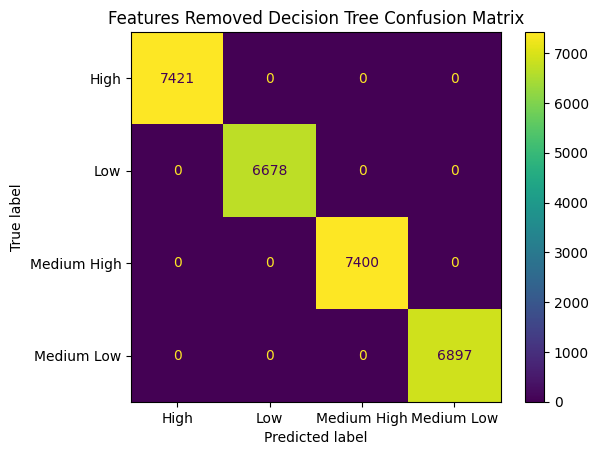

In [37]:
dt_no_month_no_tavg = dt_df.copy()
dt_x_no_month_no_tavg = dt_no_month_no_tavg.drop(columns=['label', 'tavg', 'month'])
dt_y_no_month_no_tavg = dt_no_month_no_tavg['label']

# Define preprocessing for numeric columns (impute missing values)
numeric_features = ['Hydro', 'Solar', 'Wind', 'wspd', 'prcp', 'poa']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Define preprocessing for categorical columns (one-hot encode)
categorical_features = ['eia_region', ]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
dt_X_preprocessed = preprocessor.fit_transform(dt_x_no_month_no_tavg)

dt_x_train, dt_x_test, dt_y_train, dt_y_test = train_test_split(dt_X_preprocessed, dt_y_no_month_no_tavg, test_size=0.25, random_state=42)
# pd.DataFrame(dt_x_train).to_feather('dt_x_train.feather')
# pd.DataFrame(dt_x_test).to_feather('dt_x_test.feather')



dt_model = DecisionTreeClassifier().fit(dt_x_train, dt_y_train)
dt_y_pred = dt_model.predict(dt_x_test)

from sklearn.tree import export_graphviz
import graphviz

categorical_feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features).tolist()
feature_names = numeric_features + categorical_feature_names

dot_data = export_graphviz(dt_model, out_file=None, feature_names=feature_names, class_names=dt_model.classes_, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('../images/dt_graph_no_tavg_no_month', format='png')

cm = confusion_matrix(dt_y_test, dt_y_pred, labels=dt_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot()
plt.title('Features Removed Decision Tree Confusion Matrix')
plt.savefig('../images/dt2_confusion_matrix.png')
plt.show()

# Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

/Users/dillonp/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8870967741935484
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     13575
           1       0.90      0.88      0.89     14821

    accuracy                           0.89     28396
   macro avg       0.89      0.89      0.89     28396
weighted avg       0.89      0.89      0.89     28396



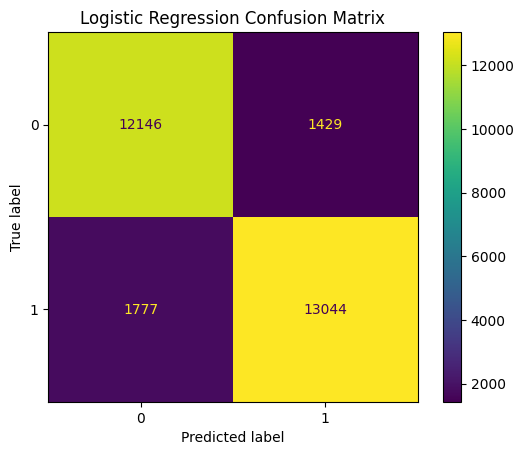

In [46]:
log_df = df.copy()
log_df['month'] = log_df['month_year'].dt.month
log_df['log_label'] = np.where(df.label.isin(['High', 'Medium High']), 1, 0)
log_df.drop(columns='label', inplace=True)
log_x_df = log_df.drop(columns='log_label')
log_y_df = log_df['log_label']

# Define preprocessing for numeric columns (impute missing values and scale)
numeric_features = ['Hydro', 'Solar', 'Wind', 'tavg', 'wspd', 'prcp', 'poa']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical columns (one-hot encode)
categorical_features = ['eia_region', 'month']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
log_X_preprocessed = preprocessor.fit_transform(log_x_df)
# Split data into training and testing sets
log_x_train, log_x_test, log_y_train, log_y_test = train_test_split(log_X_preprocessed, log_y_df, test_size=0.25, random_state=42)

# # Save the preprocessed training data
pd.DataFrame(log_x_train).to_feather('log_x_train.feather')
pd.DataFrame(log_x_test).to_feather('log_x_test.feather')

# Initialize the model
log_model = LogisticRegression(random_state=42)

# Train the model
log_model.fit(log_x_train, log_y_train)

# Make predictions
log_y_pred = log_model.predict(log_x_test)

# Evaluate the model
accuracy = accuracy_score(log_y_test, log_y_pred)
report = classification_report(log_y_test, log_y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

cm = confusion_matrix(log_y_test, log_y_pred, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.savefig('../images/log_confusion_matrix.png')
plt.show()

## Multinomial NB...again

Accuracy: 0.8676222003099028
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     13575
           1       0.89      0.86      0.87     14821

    accuracy                           0.87     28396
   macro avg       0.87      0.87      0.87     28396
weighted avg       0.87      0.87      0.87     28396



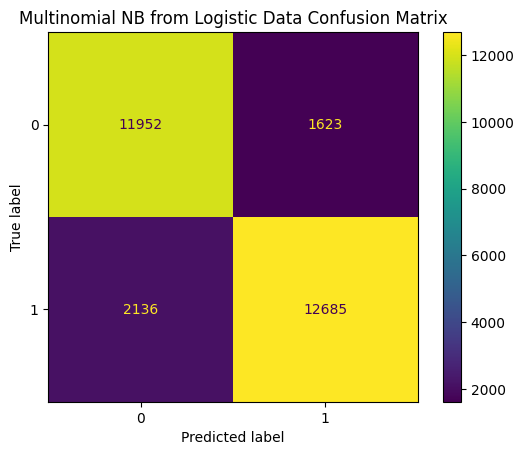

In [47]:
# Define preprocessing for numeric columns (impute missing values and scale to non-negative range)
numeric_features = ['Hydro', 'Solar', 'Wind', 'tavg', 'wspd', 'prcp', 'poa']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Define preprocessing for categorical columns (one-hot encode)
categorical_features = ['eia_region', 'month']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
log_X_preprocessed = preprocessor.fit_transform(log_x_df)

# Split data into training and testing sets
log_x_train, log_x_test, log_y_train, log_y_test = train_test_split(log_X_preprocessed, log_y_df, test_size=0.25, random_state=42)

# Train the MultinomialNB model
multi_model = MultinomialNB().fit(log_x_train, log_y_train)
multi_y_pred = multi_model.predict(log_x_test)

# Evaluate the model
accuracy = accuracy_score(log_y_test, multi_y_pred)
report = classification_report(log_y_test, multi_y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

cm = confusion_matrix(log_y_test, multi_y_pred, labels=multi_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multi_model.classes_)
disp.plot()
plt.title('Multinomial NB from Logistic Data Confusion Matrix')
plt.savefig('../images/mnb_log_confusion_matrix.png')
plt.show()